In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [2]:
# Le dataset principal qui contient toutes les images
print (mnist.data.shape)

# Le vecteur d'annotations associé au dataset (nombre entre 0 et 9)
print (mnist.target.shape)

(70000, 784)
(70000,)


In [3]:
sample = np.random.randint(70000, size=5000)
data = mnist.data[sample]
target = mnist.target[sample]

In [25]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(data, target, train_size=0.8)

In [7]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [8]:
error = 1 - knn.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.074000


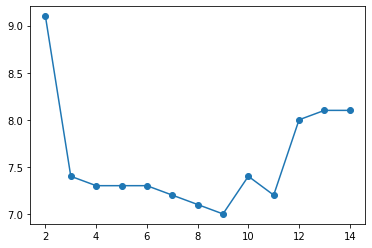

In [11]:
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

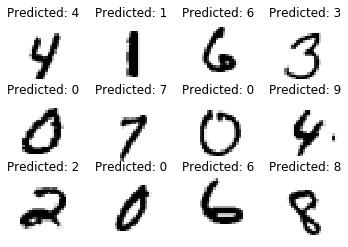

In [12]:
# On récupère le classifieur le plus performant
knn = neighbors.KNeighborsClassifier(9)
knn.fit(xtrain, ytrain)

# On récupère les prédictions sur les données test
predicted = knn.predict(xtest)

# On redimensionne les données sous forme d'images
images = xtest.reshape((-1, 28, 28))

# On selectionne un echantillon de 12 images au hasard
select = np.random.randint(images.shape[0], size=12)

# On affiche les images avec la prédiction associée
fig,ax = plt.subplots(3,4)

for index, value in enumerate(select):
    plt.subplot(3,4,index+1)
    plt.axis('off')
    plt.imshow(images[value],cmap=plt.cm.gray_r,interpolation="nearest")
    plt.title('Predicted: {}'.format( predicted[value]) )

plt.show()

# II – Classifieurs naïfs de Bayes
Deux types de classifieurs sont testés ici : `MultinomialNB` et `CategoricalNB`. Des exemples d'estimations sont donnés, la qualité des classifieurs est mesurée.

Les variables (les 784 pixels) sont catégorielles, elles peuvent prendre les valeurs entières entre `0` et `255`. 
Les données de départ, bien que des nombres entiers, sont des `float64`. Nous les avons transformés en `np.uint8` pensant que cela prendrait moins de place en mémoire et moins de temps à l'exécution, cependant, c'est le contraire pour l'exécution, surtout sur la deuxième partie (classification générale). Néanmoins, à quelques centièmes ou millièmes près, les résultats sont légèrement meilleurs avec les données de type `np.uint8`. 
Pour des soucis d'efficacité, travaillons sur les données d'origine, en `float64`.

De même, les classes à identifier peuvent être laisées telles quelles, auquel cas la classification binaire ne marchera pas, ou bien ils peuvent être transformés en `np.int8` (c'est plus sûr).

Dans les deux types de classification, les classifieurs naïfs bayésiens multinomial et gaussien seront utilisés, multinomial car les données sont catégorielles, et gaussiens « par curiosité », car comme l'âge, nous aurions pu considérer les variables comme numériques. Nous avons essayé le classifieur `CategoricalNB` de `sklearn` mais nous recontrons un problème lors du calcul du score, apparemment d'index. Cependant lorsque les prédictions sont prises une par une, ou même dans une boucle, cela marche bien. Dans tous les cas, *quel est la différence entre le `CategoricalNB` et le `MultinomialNB` ?*

D'après ce que je comprends, `CategoricalNB` est à utilisé lorsque les variables sont qualitatives avec des modalités différentes. De plus, cet algorithme suppose que les variables sont qualitatives *ordinales* (ce qui est bien le cas dans notre exemple puisque la puissance du pixel est encodée. Quant à `MultinomialNB`, cet algorithme suppose que toutes les variables suivent la même loi multinomiale ? 

En général, les classifieurs naïfs de Bayes, bien que requerrant des hypothèses irréelles (indépendance des variables) sont de bons classifieurs, surtout dans le cas d'une prédiction de classe, lorsque le $Y$ à prédire est qualitatif. Ils sont de bons classifieurs, mais de mauvais estimateurs de probabilités. Par exemple, si $\mathbb{P}(7|x) = 0.9$ et $\mathbb{P}(non-7|x) = 0.1$, le classifieur peut estimer $\mathbb{P}'(7|x) = 0.6$ et $\mathbb{P}'(\lnot 7|x) = 0.4$, qui sont de très mauvaises estimations, mais la classfication n'est pas affectée de cette mauvaise estimation de probabilité.

Il a été démontré par **Harry Zhang**, dans [*The Optimality of Naive Bayes*](https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf) que sous certaines conditions, dans le cadre de variables gaussiennes (donc du classifieur naïf gaussien) ce dernier peut être optimal/équivalent au classifieur optimal de Bayes, même lorsque l'indépendance conditionnelle n'est pas respectée. Cela arrive lorsque les dépendances entre variables « s'annulent ». Ce résultat est théorique. En pratique, lorsque nous avons deux variables explicatives gaussiennes et deux classes à prédire, ce qui va affecter la performance du classifieur naïf, c'est le rapport des distances entre les moyennes d'une variable pour les deux classes : 

$$ r = \dfrac{\mu_2^+ - \mu_2^-}{\mu_1^+ - \mu_1^-}, $$  avec $\mu_i^+$ étant la moyenne des $X_i$ dans la classe $+$.

Plus $|r|$ est petit, plus le classifieur naïf sera performant. 

Référence : **Harry Zhang**, [*The Optimality of Naive Bayes*](https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf)

In [26]:
from sklearn.naive_bayes import CategoricalNB, MultinomialNB, GaussianNB
from sklearn.metrics import balanced_accuracy_score
# xtrain, xtest = xtrain.astype(np.uint8), xtest.astype(np.uint8)
ytrain, ytest = ytrain.astype(np.int8), ytest.astype(np.int8)

## A) Sept ou pas ? classification binaire
Essayons de prédire si le chiffre entré est un sept ou pas.

In [27]:
ytrain7 = ytrain == 7
ytest7 = ytest == 7

### 1. Classifieur multinomial : `MultinomialNB`

In [28]:
clf_7M = MultinomialNB()
clf_7M.fit(xtrain, ytrain7)
for i in range(5) :
    print(clf_7M.predict(xtest[i:i+1]), 
          ytest7[i], 
          ytest[i : i+1])

score_7M = clf_7M.score(xtest, ytest7)
balanced_score_7M = balanced_accuracy_score(clf_7M.predict(xtest), ytest7)
print(score_7M, balanced_score_7M)

[False] False [9]
[False] False [4]
[False] False [4]
[False] False [3]
[False] False [8]
0.922 0.7858548663576916


La méthode `score` calcule le nombre de prédiction correctement effectuées **en tout**. Ainsi, dans une classification binaire comme celle-ci, avec un jeu de données déséquilibré (il y a plus de non-`7` que de `7`) beaucoup de prédiction se porteront sur des non-`7`, ce qui ne sera pas faux, d'où la mesure élevée. En revanche, il y aura un plus faible nombre de `7` correctement prédit. C'est là que la fonction `balanced_accuracy_score` de `sklearn.metrics` est utile car elle pondère ces résultats et nous remet les pieds sur Terre ! 

### 2. Classifieur catégoriel : `CategoricalNB`

In [14]:
clf_7C = CategoricalNB()
clf_7C.fit(xtrain, ytrain7)
for i in range(5) :
    print(clf_7C.predict(xtest[i:i+1]), 
          ytest7[i], 
          ytest[i : i+1])

# erreur à suivre :
# score_7C = clf_7C.score(test_data, test_7target)
# balanced_score_7C = balanced_accuracy_score(clf_7C.predict(xtest), ytest7)
# print(score_7C, balanced_score_7C)

[False] False [9]
[False] True [7]
[False] False [8]
[False] False [2]
[False] False [1]


##  B) 0 ? 1 ? ... 9 ? : classification générale
Essayons de prédire le chiffre.
### 1. `MultinomialNB`

In [29]:
clf_M = MultinomialNB()
clf_M.fit(xtrain, ytrain)
for i in range(5) :
    print(clf_M.predict(xtest[i:i+1]), 
          ytest[i])

score_M = clf_M.score(xtest, ytest)
balanced_score_M = balanced_accuracy_score(clf_M.predict(xtest), ytest)
print(score_M, balanced_score_M)

[9] 9
[8] 4
[4] 4
[3] 3
[1] 8
0.816 0.8257510283408699


Ici, le jeu de données est plus équilibré, d'où la faible différence entre les deux mesures.
Cette différence peut être d'autant plus réduite que, lors de la séparation du jeu de données en une base d'entraînement et de test, on indique à `sklearn` de distribuer, tant que faire se peut, équitablement les données entre les deux bases (proportionnellement autant de `0` que de `1` que de `2`... dans la base d'entraînement que dans la base de test) :  

In [30]:
xtrain, xtest, ytrain, ytest = train_test_split(data, target, train_size = 0.8, stratify = target) # option stratify = target !
ytrain, ytest = ytrain.astype(np.int8), ytest.astype(np.int8)

clf_M = MultinomialNB()
clf_M.fit(xtrain, ytrain)
for i in range(5) :
    print(clf_M.predict(xtest[i:i+1]), 
          ytest[i])

score_M = clf_M.score(xtest, ytest)
balanced_score_M = balanced_accuracy_score(clf_M.predict(xtest), ytest)
print(score_M, balanced_score_M)

[8] 8
[1] 1
[3] 3
[2] 2
[1] 1
0.84 0.8476874068516572


*Cool, la mesure en est même encore améliorée !*

### 2. `CategoricalNB`

In [19]:
clf_C = CategoricalNB()
clf_C.fit(xtrain, ytrain)
for i in range(5) :
    print(clf_C.predict(xtest[i:i+1]), 
          ytest[i])

# score_C = clf_C.score(xtest, ytest)
# balanced_score_C = balanced_accuracy_score(clf_C.predict(xtest), ytest)
# print(score_C, balanced_score_C)

# Dommage que le score ne fonctionne pas 
# car la première prédiction est bonne contrairement à celle du classifieur multinomial !

[7] 9
[7] 7
[8] 8
[2] 2
[1] 1


## C) Et en grande dimension ?
`sklearn` permet de gérer le fléau de la grande dimension grâce à la méthode `partial_fit` qui permet de d'apprendre petit à petit, ou bien de se mettre à jour toutes les semaines par exemple, sans avoir à tout réapprendre à chaque fois. Nous en montrons un exemple, sur l'ensemble des données : 

In [13]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(mnist['data'], mnist['target'].astype(np.int8), train_size=0.8, stratify = mnist['target'])

### 1. `MultinomialNB().partial_fit()`

In [14]:
clf_Mpf = MultinomialNB()
for i in range(7) :
    clf_Mpf.partial_fit(Xtrain[i : 10000*(i+1)], 
                        Ytrain[i : 10000*(i+1)], 
                        np.unique(Ytrain))
    score_Mpf = clf_Mpf.score(Xtest, Ytest)
    print(score_Mpf)

clf_M = MultinomialNB()
clf_M.fit(Xtrain, Ytrain)
score_M = clf_M.score(Xtest, Ytest)
print(score_M)

0.8304285714285714
0.8290714285714286
0.8282142857142857
0.8291428571428572
0.8287857142857142
0.8288571428571428
0.829
0.8292857142857143


*Visiblement, le score est plus petit au début qu'à la fin. Pourquoi ? J'ai lu à plusieurs reprises que les classifieurs de Bayes obtenaient de bons résultats même avec de petits jeux d'entraînement, mais pourquoi seraient-ils moins bons à mesure que l'entraînement s'intensifie ? À part ça, nous avons bien le même score après avoir entraîné tout le modèle en plusieurs fois que tout le modèle d'un coup.*